# Inference of MetaCell from Single-Cell RNA-seq

Metacells are cell groupings derived from single-cell sequencing data that represent highly granular, distinct cell states. Here, we present single-cell aggregation of cell-states (SEACells), an algorithm for identifying metacells; overcoming the sparsity of single-cell data, while retaining heterogeneity obscured by traditional cell clustering.

Paper: [SEACells: Inference of transcriptional and epigenomic cellular states from single-cell genomics data](https://www.nature.com/articles/s41587-023-01716-9)

Code: https://github.com/dpeerlab/SEACells


In [1]:
import omicverse as ov
import scanpy as sc
import scvelo as scv

ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.8, Tutorials: https://omicverse.readthedocs.io/


## Data preprocessed

We need to normalized and scale the data at first.

In [3]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [4]:
#quantity control
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.20, 'nUMIs': 500, 'detected_genes': 250},
              mt_startswith='mt-')
#normalize and high variable genes (HVGs) calculated
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)

#save the whole genes and filter the non-HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

#scale the adata.X
ov.pp.scale(adata)

#Dimensionality Reduction
ov.pp.pca(adata,layer='scaled',n_pcs=50)

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 3696
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 12261 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 56.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%
    Scrublet finished (0:00:25)
Cells retained after scrublet: 3688, 8 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower tresho

## Constructing a metacellular object

We can use `ov.single.MetaCell` to construct a metacellular object to train the SEACells model, the arguments can be found in below.

- :param ad: (AnnData) annotated data matrix
- :param build_kernel_on: (str) key corresponding to matrix in ad.obsm which is used to compute kernel for metacells
                        Typically 'X_pca' for scRNA or 'X_svd' for scATAC
- :param n_SEACells: (int) number of SEACells to compute
- :param use_gpu: (bool) whether to use GPU for computation
- :param verbose: (bool) whether to suppress verbose program logging
- :param n_waypoint_eigs: (int) number of eigenvectors to use for waypoint initialization
- :param n_neighbors: (int) number of nearest neighbors to use for graph construction
- :param convergence_epsilon: (float) convergence threshold for Franke-Wolfe algorithm
- :param l2_penalty: (float) L2 penalty for Franke-Wolfe algorithm
- :param max_franke_wolfe_iters: (int) maximum number of iterations for Franke-Wolfe algorithm
- :param use_sparse: (bool) whether to use sparse matrix operations. Currently only supported for CPU implementation.

In [5]:
meta_obj=ov.single.MetaCell(adata,use_rep='scaled|original|X_pca',
                            n_metacells=None,
                           use_gpu=False)

Welcome to SEACells!


In [6]:
%%time
meta_obj.initialize_archetypes()

Computing kNN graph using scanpy NN ...
computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/3688 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/3688 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/3688 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on scaled|original|X_pca
Computing diffusion components from scaled|original|X_pca for waypoint initialization ... 
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
Done.
Sampling waypoints ...
Done.
Selecting 41 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 448.54it/s]

Selecting 8 cells from greedy initialization.
CPU times: user 10.5 s, sys: 3.39 s, total: 13.9 s
Wall time: 7.07 s


## Train and save the model

In [7]:
%%time
meta_obj.train(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.10913
Starting iteration 1.
Completed iteration 1.
Converged after 8 iterations.
Converged after 9 iterations.
Starting iteration 10.
Completed iteration 10.
Converged after 10 iterations.
CPU times: user 1min 6s, sys: 12.6 s, total: 1min 19s
Wall time: 11.8 s


In [8]:
meta_obj.save('seacells/model.pkl')

In [6]:
meta_obj.load('seacells/model.pkl')

## Predicted the metacells

we can use `predicted` to predicted the metacells of raw scRNA-seq data. There are two method can be selected, one is `soft`, the other is `hard`. 

In the `soft` method, Aggregates cells within each SEACell, summing over all raw data x assignment weight for all cells belonging to a SEACell. Data is un-normalized and pseudo-raw aggregated counts are stored in .layers['raw']. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

In the `hard` method, Aggregates cells within each SEACell, summing over all raw data for all cells belonging to a SEACell. Data is unnormalized and raw aggregated counts are stored .layers['raw']. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

In [7]:
ad=meta_obj.predicted(method='soft',celltype_label='clusters',
                     summarize_layer='lognorm')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 47.36it/s]


## Benchmarking

Benchmarking metrics were computed for each metacell for all combinations of data modality, dataset and method. Cell type purity was used to assess the quality of PBMC metacells. Methods were compared using the Wilcoxon rank-sum test. We note that this test might possibly inflate significance due to the dependency between metacells, but it nonetheless provides an estimate of the direction of difference. Top-performing metacell approaches should have scores that are low on compactness, high on separation and high on cell type purity 

In [8]:
SEACell_purity = meta_obj.compute_celltype_purity('clusters')
separation = meta_obj.separation(use_rep='scaled|original|X_pca',nth_nbr=1)
compactness = meta_obj.compactness(use_rep='scaled|original|X_pca')

computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


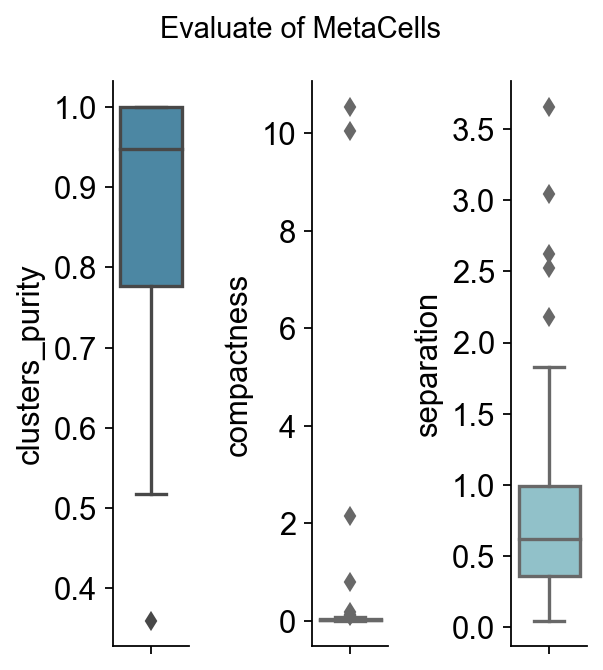

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
ov.plot_set()
fig, axes = plt.subplots(1,3,figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='clusters_purity',ax=axes[0],
           color=ov.utils.blue_color[3])
sns.boxplot(data=compactness, y='compactness',ax=axes[1],
           color=ov.utils.blue_color[4])
sns.boxplot(data=separation, y='separation',ax=axes[2],
           color=ov.utils.blue_color[4])
plt.tight_layout()
plt.suptitle('Evaluate of MetaCells',fontsize=13,y=1.05)
for ax in axes:
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

<AxesSubplot: title={'center': 'Meta cells'}, xlabel='X_umap1', ylabel='X_umap2'>

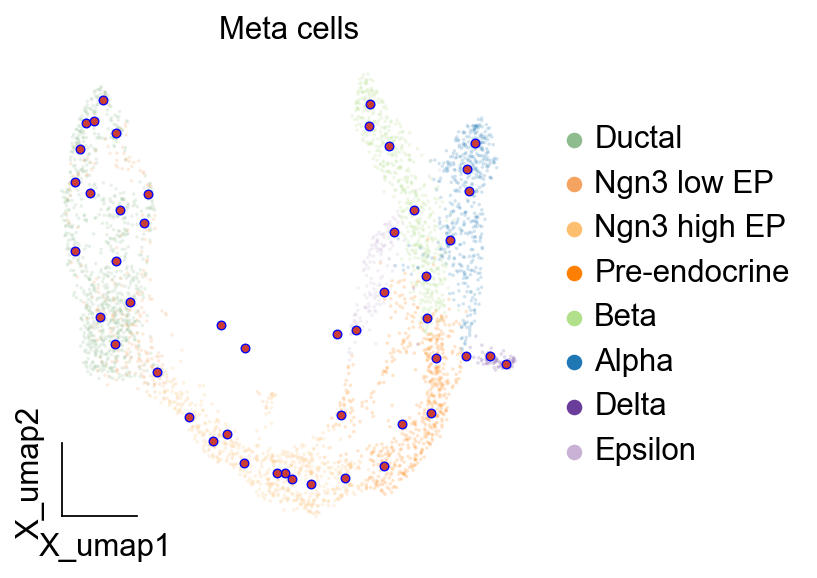

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))
ov.utils.embedding(
    meta_obj.adata,
    basis="X_umap",
    color=['clusters'],
    frameon='small',
    title="Meta cells",
    #legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    size=10,
    ax=ax,
    alpha=0.2,
    #legend_loc='', 
    add_outline=False, 
    #add_outline=True,
    outline_color='black',
    outline_width=1,
    show=False,
    #palette=ov.utils.blue_color[:],
    #legend_fontweight='normal'
)
ov.single.plot_metacells(ax,meta_obj.adata,color='#CB3E35',
                                  )

## Get the raw obs value from adata

There are times when we compute some floating point type data such as pseudotime on the raw single cell data. We want to get the result of the original data on the metacell, in this case, we can use the `ov.single` function to get it.

Note that the type parameter supports `str`,`max`,`min`,`mean`.

In [11]:
ov.single.get_obs_value(ad,adata,groupby='S_score',
                       type='mean')
ad.obs.head()

... S_score have been added to ad.obs[S_score]


,Pseudo-sizes,celltype,celltype_purity,S_score
0,116.415636,Beta,0.983513,-0.221082
1,44.727988,Ngn3 high EP,0.998283,-0.061610
2,112.080394,Ngn3 low EP,0.486704,-0.104088
3,90.552187,Epsilon,0.697957,-0.175657
4,111.563672,Pre-endocrine,0.985779,-0.219417


## Visualize the MetaCells

In [12]:
import scanpy as sc
ad.raw=ad.copy()
sc.pp.highly_variable_genes(ad, n_top_genes=2000, inplace=True)
ad=ad[:,ad.var.highly_variable]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [13]:
ov.pp.scale(ad)
ov.pp.pca(ad,layer='scaled',n_pcs=30)
sc.pp.neighbors(ad, n_neighbors=15, n_pcs=20,
               use_rep='scaled|original|X_pca')

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [14]:
sc.tl.umap(ad)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


We want the metacells to take on the same colours as the original data, a noteworthy fact is that the colours of the original data are stored in the `adata.uns['_colors']`

In [15]:
ad.obs['celltype']=ad.obs['celltype'].astype('category')
ad.obs['celltype']=ad.obs['celltype'].cat.reorder_categories(adata.obs['clusters'].cat.categories)
ad.uns['celltype_colors']=adata.uns['clusters_colors']

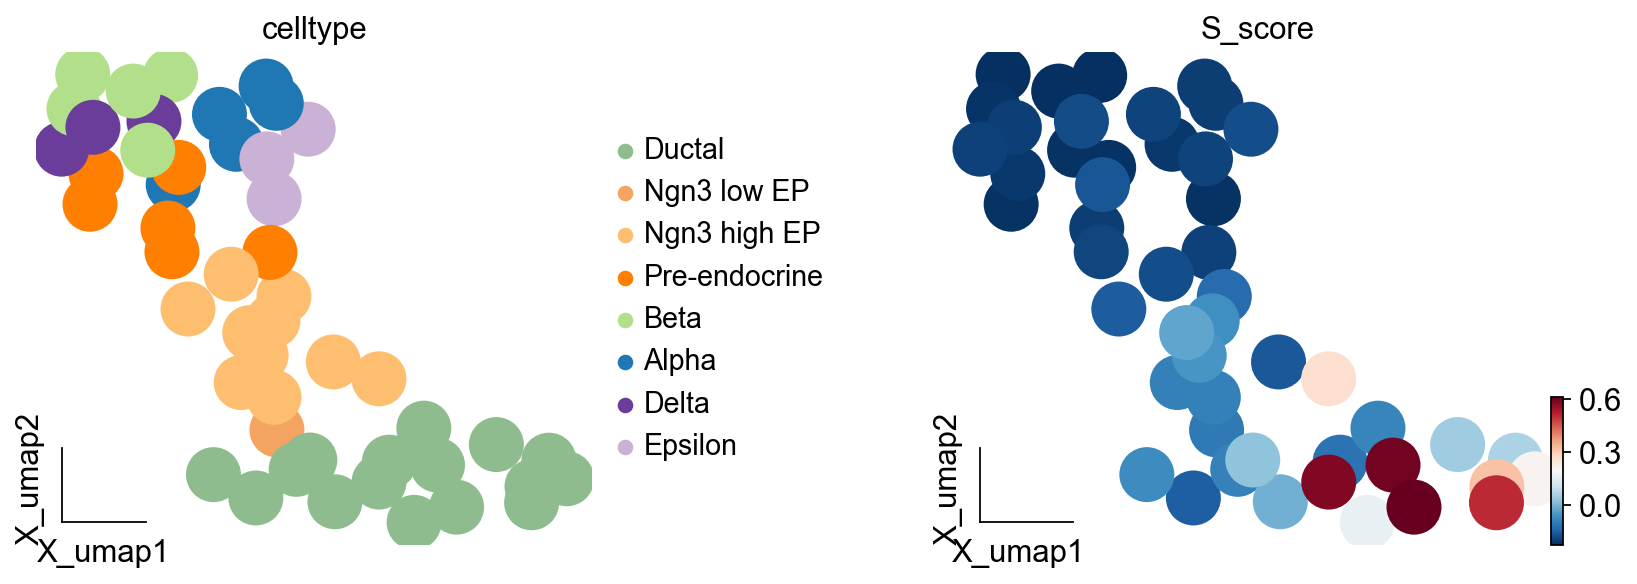

In [16]:
ov.pl.embedding(ad, basis='X_umap',
                color=["celltype","S_score"],
                frameon='small',cmap='RdBu_r',
               wspace=0.5)